In [1]:
# Thanks https://ithelp.ithome.com.tw/articles/10301854


In [2]:
!pip install transformers datasets pipeline

In [3]:
from datasets import load_dataset

In [4]:
sentiment = load_dataset("poem_sentiment")

In [5]:
sentiment

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [6]:
sentiment.set_format(type='pandas')

In [7]:
df = sentiment['train'][:]

In [8]:
#df

In [9]:
df.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


In [10]:
labels = sentiment['train'].features["label"].names

In [11]:
labels

['negative', 'positive', 'no_impact', 'mixed']

In [12]:
def label_int2str(row):
  return sentiment["train"].features["label"].int2str(row)

In [13]:
df["label_names"] = df["label"].apply(label_int2str)


In [14]:
df.head()

,id,verse_text,label,label_names
0,0,with pale blue berries. in these peaceful shad...,1,positive
1,1,"it flows so long as falls the rain,",2,no_impact
2,2,"and that is why, the lonesome day,",0,negative
3,3,"when i peruse the conquered fame of heroes, an...",3,mixed
4,4,of inward strife for truth and liberty.,3,mixed


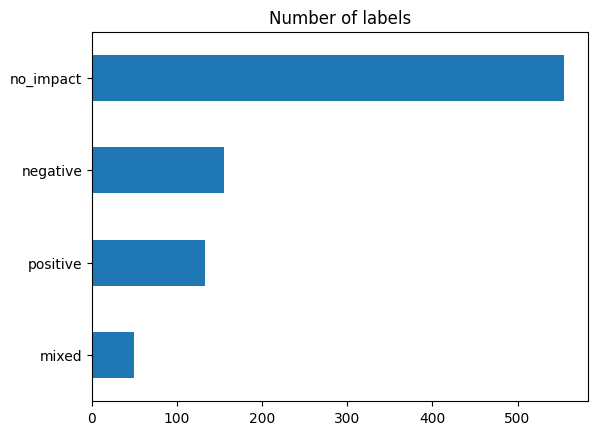

In [15]:
import matplotlib.pyplot as plt
df["label_names"].value_counts(ascending=True).plot.barh()
plt.title("Number of labels")
plt.show()

In [16]:
# Reset dataset

In [17]:
sentiment.reset_format()

In [18]:
from transformers import AutoTokenizer

In [19]:
model_name = "distilbert-base-uncased"

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
def tokenize(batch):
  return tokenizer(batch["verse_text"],padding=True, truncation=True)

In [22]:
sentiment_encoded = sentiment.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [23]:
next(iter(sentiment_encoded["train"]))

{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1,
 'input_ids': [101,
  2007,
  5122,
  2630,
  22681,
  1012,
  1999,
  2122,
  9379,
  13178,
  1011,
  1011,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [24]:
# Train model

In [25]:
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]

In [26]:
from transformers import AutoModelForSequenceClassification
import torch
model_name = "distilbert-base-uncased"

In [27]:
num_labels = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:
model = (AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels
	,id2label={ "0": "negative",
				"1": "positive",
				"2": "no_impact",
				"3": "mixed"}
    ,label2id={"negative": "0",
            "positive": "1",
            "no_impact": "2",
            "mixed": "3" })
    .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
!pip install -U accelerate


In [32]:
!pip install -U transformers


In [33]:
!pip install transformers[torch]

In [34]:
from transformers import Trainer, TrainingArguments

In [35]:
batch_size = 64
logging_steps = len(sentiment_encoded["train"])
model_name = "poem_model"

In [36]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.32.1', '0.22.0')

In [37]:
training_args = TrainingArguments(output_dir=model_name,
    num_train_epochs=40,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    label_names= labels,
    report_to = "azure_ml",
    logging_steps=logging_steps)

In [38]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy":acc, "f1":f1}

In [39]:
# Now let's train

In [40]:
!pip install azureml-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.1/811.1 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = sentiment_encoded["train"],
                  eval_dataset=sentiment_encoded["validation"],
                  tokenizer = tokenizer)


In [42]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,No log
2,No log,No log
3,No log,No log
4,No log,No log
5,No log,No log
6,No log,No log
7,No log,No log
8,No log,No log
9,No log,No log
10,No log,No log


Attempted to log scalar metric eval_runtime:
0.1224
Attempted to log scalar metric eval_samples_per_second:
857.525
Attempted to log scalar metric eval_steps_per_second:
16.334
Attempted to log scalar metric epoch:
1.0
Attempted to log scalar metric eval_runtime:
0.1044
Attempted to log scalar metric eval_samples_per_second:
1006.203
Attempted to log scalar metric eval_steps_per_second:
19.166
Attempted to log scalar metric epoch:
2.0
Attempted to log scalar metric eval_runtime:
0.1115
Attempted to log scalar metric eval_samples_per_second:
941.299
Attempted to log scalar metric eval_steps_per_second:
17.93
Attempted to log scalar metric epoch:
3.0
Attempted to log scalar metric eval_runtime:
0.1089
Attempted to log scalar metric eval_samples_per_second:
963.773
Attempted to log scalar metric eval_steps_per_second:
18.358
Attempted to log scalar metric epoch:
4.0
Attempted to log scalar metric eval_runtime:
0.1371
Attempted to log scalar metric eval_samples_per_second:
766.1
Attempted 

TrainOutput(global_step=560, training_loss=0.14221578325544085, metrics={'train_runtime': 112.9972, 'train_samples_per_second': 315.76, 'train_steps_per_second': 4.956, 'total_flos': 258486230768640.0, 'train_loss': 0.14221578325544085, 'epoch': 40.0})

In [43]:
#Use pipeline

In [45]:
from transformers import pipeline
classifier = pipeline(task='sentiment-analysis', model='poem_model/checkpoint-500')

In [47]:
classifier(
    [
        "Only those who will risk going too far can possibly find out how far one can go.",
        "Baby shark, doo doo doo doo doo doo, Baby shark!"
    ]
)

[{'label': 'no_impact', 'score': 0.9904470443725586},
 {'label': 'no_impact', 'score': 0.9784638285636902}]